# IF240 - Apprentissage et deep learning

## Practice 2: Naive Bayes, Evaluation Metrics, SVM 

By Aurélie Bugeau
Credits:  Vincent Lepetit, Varun Kumar, Mohit Deshpande

### Objectives 
The objective of the practice is to clssifiy emails from a dataset as spam or non-spam. 
You will compare diffrent classification methods: Naive Bayes and SVM, ans implement several validation metrics

### Libraries
The code needs to import the following libraries

In [1]:
import pandas as pd
import numpy as np
import math
import re
import string

## 1 Dataset

#### Presentation and Loading
The dataset used here contained 747 spam and 4825 non-spam (i.e. ham) mails. 
Emails in the corpus have been already pre-processed in the following ways:
Removal of stop words (and, the, of, etc) and lemmatization (inludes, included, include are now all considered as include)

In [2]:
#Open the dataset
mails = pd.read_csv("spamham.csv")
#count the number of spam/ham mails
count = mails['Category'].value_counts()
print(count)
print(mails.head(), '\n')

ham     4825
spam     747
Name: Category, dtype: int64
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro... 



#### Training and evaluation sets
Split the dataset into training and evaluation sets.

In [3]:
# split data as train and evaluation sets. 
msk = np.random.rand(len(mails)) < 0.8
training_set = mails[msk]
testing_set = mails[~msk]

## 2 Naive Bayes Classification
The classifier must be able to predict the label based on the text by implementing the following pseudo code:

`
if (P('ham' | message ) > P( 'spam' | message )) {
  return ‘ham’;
} 
else {
  return ‘spam’;
}
`

where
$$ P(ham | message)~=~ {\rm Probability ~that~ email~ is ~ham~ given~ that~ it~ has~ certain~ features~} $$
The features can for instance be a set of given words.
$$ P(spam | message)~=~ {\rm Probability ~that~ email~ is ~spam~ given~ that~ it~ has~ certain~ features~} $$



### Question 1 

Apply the Naive Bayes formula in the following code to implement a classifier. You will consider that:
$$P(message | spam) = P(word1 | spam) * P(word2 | spam) *...$$

 
_Note:_ if a word in the testing dataset is not present in the training dataset, you may encounter problems as $P(new | ham)$ or $P(new | spam)$ will be 0 making all product equal to 0.
To solve this problem, we should take log on both sides. New pseudo code will be

`
if (log(P('ham' | message )) > log(P('spam' | message))) {
  return ‘ham’;
} else {
  return ‘spam’;
}
`

Then 
$$ log(P(message| spam)) =  log(P(word1 | spam)) + log(P(word2 | spam)) …$$

But the problem is still not solved. If the classifier encounters a new word that is not present in our training data sets then P(new-word | category) will be 0 and log(0) is undefined. To solve this problem, you must use Laplace smoothing:

$$P(word1 | spam) = \frac{{\rm number~ of ~}word1 {\rm~belonging~ to ~category~ spam + 1}}{{\rm  number ~ of ~words~ belonging~ to ~ham ~}+{ \rm ~number ~of~ distinct ~words~ in ~training ~datasets~}}$$


In [4]:
#tokenize a string into words
def tokenize(text):
    return re.split("\W+", text)

class SpamDetectorNB(object):

    def __init__(self):
        self.numberOfmessages = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.word_index = {}
        self.vocab = set()


    # compute log class priors log(𝑃(ℎ𝑎𝑚)) and log(𝑃(sp𝑎𝑚))
    #by counting up how many spam/ham messages are in our dataset and dividing by the total number
    def log_priors(self, training_set):
        spam = 0
        ham = 0
        for _, mail in training_set.iterrows():
            label = mail['Category']
            if(label == 'spam'):
                spam+=1
            else:
                ham+=1

        self.log_class_priors['spam'] = np.log(spam/(spam+ham))
        self.log_class_priors['ham'] = np.log(ham/(spam+ham))


    #Count how many times each word appears in a text.
    #Returns a dictionary that contain for each word indicates the number of times it appears in text.
    def get_word_counts(self, text):
        word_counts = {}
        for word in text:
            if(word in word_counts):
                word_counts[word]+=1
            else:
                word_counts[word]=1
        return word_counts

    #Create a dictionary (a vocabulary of words)
    #and count words frequency for spam and ham separately
    def get_word_frequency(self, training_set):
        self.word_counts['spam'] = {}
        self.word_counts['ham'] = {}
        for _, mail in training_set.iterrows():
            label = mail['Category']
            text = mail['Message']
            #Tokenize each message into words.
            counts = self.get_word_counts(tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.word_index[word] = len(self.vocab)
                    self.vocab.add(word)
                if word not in self.word_counts[label]:
                    self.word_counts['spam'][word] = 0.0
                    self.word_counts['ham'][word] = 0.0
                self.word_counts[label][word] += count


    #compute all necessary features
    def train(self, training_set):
        self.log_priors(training_set)
        self.get_word_frequency(training_set)


    def predict(self, testing_set):
        result = []
        for _, mail in testing_set.iterrows():
            label = mail['Category']
            text = mail['Message']

            #Tokenize each message into words.
            counts = self.get_word_counts(tokenize(text))

            #Initialize 𝑙𝑜𝑔(𝑃(spam|message)) and 𝑙𝑜𝑔(𝑃(ham|message))  according to log priors
            log_m_spam = 0
            log_m_ham = 0

            #For each message, compute 𝑙𝑜𝑔(𝑃(𝑚𝑒𝑠𝑠𝑎𝑔𝑒|𝑠𝑝𝑎𝑚)) and 𝑙𝑜𝑔(𝑃(𝑚𝑒𝑠𝑠𝑎𝑔𝑒|𝑠𝑝𝑎𝑚))
            for word, _ in counts.items():
                if word not in self.vocab: continue
                #For each word compute log(P(w/spam)) and log(P(w/ham))
                if(word not in self.word_counts['spam']):
                    log_w_spam = np.log(1/(len(self.word_counts['spam'])+len(self.vocab)))
                else:
                    log_w_spam = np.log((self.word_counts['spam'][word]+1)/(len(self.word_counts['spam'])+len(self.vocab)))

                if(word not in self.word_counts['ham']):
                    log_w_ham = np.log(1/(len(self.word_counts['ham'])+len(self.vocab)))
                else:
                    log_w_ham = np.log((self.word_counts['ham'][word]+1)/(len(self.word_counts['ham'])+len(self.vocab)))
                #Update 𝑙𝑜𝑔(𝑃(𝑚𝑒𝑠𝑠𝑎𝑔𝑒|𝑠𝑝𝑎𝑚)) and 𝑙𝑜𝑔(𝑃(𝑚𝑒𝑠𝑠𝑎𝑔𝑒|𝑠𝑝𝑎𝑚))
                log_m_spam += log_w_spam
                log_m_ham += log_w_ham


            #decide spam or ham
            log_spam_message = log_m_spam + self.log_class_priors['spam']
            log_ham_message = log_m_ham + self.log_class_priors['ham']

            if(log_spam_message >= log_ham_message):
                result.append([label,'spam'])
            else:
                result.append([label,'ham'])

        return result

sd = SpamDetectorNB()
sd.train(training_set)
result = sd.predict(testing_set)

### Question 2 - Accuracy and confution matrix
Compute the precision, recall, accuracy and confusion matrix

In [5]:
def TP(result):
    tp = 0
    for i in range(len(result)):
        tp += ((result[i][0]=='spam')and(result[i][1]=='spam'))
    return tp

def FP(result):
    fp = 0
    for i in range(len(result)):
        fp += ((result[i][0]=='ham')and(result[i][1]=='spam'))
    return fp

def TN(result):
    tn = 0
    for i in range(len(result)):
        tn += ((result[i][0]=='spam')and(result[i][1]=='ham'))
    return tn

def FN(result):
    fn = 0
    for i in range(len(result)):
        fn += ((result[i][0]=='ham')and(result[i][1]=='ham'))
    return fn


print("Precision: ",TP(result)/(TP(result)+FP(result))*100,"%")
print("Recall: ",TP(result)/(TP(result)+FN(result))*100,"%")
print("Accuracy ",(TP(result)+FP(result))/(TP(result)+FP(result)+TN(result)+FN(result))*100,"%")
print("Confusion matrix using SpamDetectorNB : \n",np.array([[TN(result),FP(result)],[FN(result),TP(result)]]))


Precision:  100.0 %
Recall:  8.256029684601113 %
Accuracy  7.897071872227151 %
Confusion matrix using SpamDetectorNB : 
 [[ 49   0]
 [989  89]]


### Question 3 - Naive Bayes with Scikit-learn library
The Scikit-learn library proposes many functions for machine learning.  Study the documentation of the  MultinomialNB function and apply it for spam detection.

You will need to convert the dataset into arrays


In [6]:
import string
def text_process(mess):
    #Check characters to see if there are punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    #Join the characters again
    nopunc = "".join(nopunc)

    #Remove stopwords
    return [word for word in nopunc.split() if word.lower()]

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def vectorization(set):
  bow_transformer = CountVectorizer(analyzer = text_process).fit(set["Message"])

  set_bow = bow_transformer.transform(set["Message"])

  tfid_transformer = TfidfTransformer().fit(set_bow)
  set_tfidf = tfid_transformer.transform(set_bow)
  return set_tfidf

vect_mails = vectorization(mails)

vect_train_set = vect_mails[msk]
y_train = mails["Category"][msk]
vect_test_set = vect_mails[~msk]
y_test = mails["Category"][~msk]

In [7]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(vect_train_set, y_train)

y_pred = classifier.predict(vect_test_set)

### Question 4 - Evaluation with Scikit-learn library
The Scikit-learn library also proposes  functions to evaluate machine learning methods. Apply them to the spam detection problem

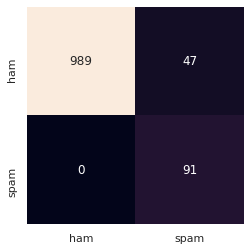

In [8]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y_test, y_pred)
cmMNb = confusion_matrix(y_test, y_pred, labels=["ham", "spam"])

cmMNb = pd.DataFrame(cmMNb, index = ["ham", "spam"],
                  columns = ["ham", "spam"])

#for visualisation of the confusion matrix
import seaborn as sns; sns.set()  # for plot styling
sns.heatmap(cmMNb.T, square=True, annot=True, fmt='d', cbar=False) # xticklabels=,yticklabels=


### Question 5 - SVM Scikit-learn library
Apply SVM with a linear kernel to the spam dataset. 

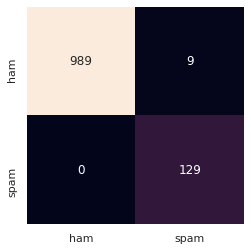

In [9]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(vect_train_set, y_train)

y_pred = clf.predict(vect_test_set)

accuracy_score(y_test, y_pred)
cmMNb = confusion_matrix(y_test, y_pred, labels=["ham", "spam"])

cmMNb = pd.DataFrame(cmMNb, index = ["ham", "spam"],
                  columns = ["ham", "spam"])

#for visualisation of the confusion matrix
import seaborn as sns; sns.set()  # for plot styling
sns.heatmap(cmMNb.T, square=True, annot=True, fmt='d', cbar=False) # xticklabels=,yticklabels=
